In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# models
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score,roc_curve,auc
import xgboost as xgb
from xgboost import XGBClassifier


# model tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval


import warnings
warnings.filterwarnings("ignore")


Read Data

In [2]:
data = pd.read_csv('hk201819.csv')
data = data.dropna()
# print(data.describe())



x = data[['H1aA', 'H1aB', 'H1bA', 'H1bB', 'H1cA', 'H1cB',
          'H1dA', 'H1dB', 'H1eA', 'H1eB', 'H1fA', 'H1fB', 'H1gA', 'H1gB', 'H2a', 'H2b', 'H2c', 'H2d', 'H2e', 'H2f',
          'H2g', 'H2h', 'H2i', 'H2j']]
y = data[['sCPS']]

In [3]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=2023, train_size=0.8)


scaler_x_train = preprocessing.StandardScaler().fit(x_train)

x_train = scaler_x_train.transform(x_train)

scaler_x_test = preprocessing.StandardScaler().fit(x_test)

x_test = scaler_x_test.transform(x_test)

Train the Model

K-Nearest Neighbors Algorithm with GridSearchCV

In [19]:
model_knn = GridSearchCV(estimator=KNeighborsClassifier(),
                         param_grid={'n_neighbors': range(2, 50)}, cv=10).fit(x_train, y_train)
print(model_knn.best_params_)
print('KNN, Training set score:', round(model_knn.score(x_train, y_train) * 100, 4))
print('KNN, Test set score:', round(model_knn.score(x_test, y_test) * 100, 4))

{'n_neighbors': 42}
KNN, Training set score: 65.117
KNN, Test set score: 64.2127


Random Forest Classifier with HyperOpt

In [5]:
def hyperopt_rf_score(params):
    clf = RandomForestClassifier(**params)
    current_score = cross_val_score(clf, x_train, y_train, cv=10).mean()
    print(current_score, params)
    return current_score

space_rf = {
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'max_depth': hp.choice('max_depth', range(2,400)),
    'max_features': hp.choice('max_features', range(2,10))
}

best = fmin(fn=hyperopt_rf_score, space=space_rf, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.6318581453291351                                                              
{'criterion': 'gini', 'max_depth': 376, 'max_features': 8}                      
0.6083387605722873                                                              
{'criterion': 'entropy', 'max_depth': 3, 'max_features': 5}                     
0.635594540233708                                                               
{'criterion': 'entropy', 'max_depth': 220, 'max_features': 4}                   
0.634926053933709                                                               
{'criterion': 'entropy', 'max_depth': 118, 'max_features': 5}                   
0.6359882561252514                                                              
{'criterion': 'entropy', 'max_depth': 152, 'max_features': 4}                   
0.6388590979449302                                                              
{'criterion': 'gini', 'max_depth': 249, 'max_features': 2}                      
0.6381904414797195          

In [6]:
params = space_eval(space_rf, best)
params

{'criterion': 'entropy', 'max_depth': 3, 'max_features': 5}

In [7]:
model_random_forest = RandomForestClassifier(**params)
model_random_forest.fit(x_train, y_train)
model_random_forest.score(x_train, y_train)
print('Random Forest Classifier, Training set score:', round(model_random_forest.score(x_train, y_train) * 100, 4))
print('Random Forest Classifier, Test set score:', round(model_random_forest.score(x_test, y_test) * 100, 4))

Random Forest Classifier, Training set score: 60.9243
Random Forest Classifier, Test set score: 61.7902


AdaBoost Classifier

In [8]:
def hyperopt_ab_score(params):
    clf = AdaBoostClassifier(**params)
    current_score = cross_val_score(clf, x_train, y_train, cv=10).mean()
    print(current_score, params)
    return current_score

space_ab = {
    'n_estimators': hp.choice('n_estimators', range(50, 1000)),
    'learning_rate': hp.quniform('learning_rate', 0, 0.05, 0.0001)
}

best = fmin(fn=hyperopt_ab_score, space=space_ab, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.5108311549607955                                                              
{'learning_rate': 0.0207, 'n_estimators': 971}                                  
0.5867455377267102                                                              
{'learning_rate': 0.0449, 'n_estimators': 239}                                  
0.5791543902779355                                                              
{'learning_rate': 0.0018000000000000002, 'n_estimators': 931}                   
0.4383072831020066                                                              
{'learning_rate': 0.044500000000000005, 'n_estimators': 772}                    
0.5830874806978505                                                              
{'learning_rate': 0.0161, 'n_estimators': 426}                                  
0.5002522931309256                                                              
{'learning_rate': 0.0337, 'n_estimators': 618}                                  
0.5791543902779355          

In [9]:
params = space_eval(space_ab, best)
params

{'learning_rate': 0.044500000000000005, 'n_estimators': 772}

In [10]:
model_ada_boost = AdaBoostClassifier(**params)
model_ada_boost.fit(x_train, y_train)
print('AdaBoost Classifier, Training set score:', round(model_ada_boost.score(x_train, y_train) * 100, 4))
print('AdaBoost Classifier, Test set score:', round(model_ada_boost.score(x_test, y_test) * 100, 4))

AdaBoost Classifier, Training set score: 44.7512
AdaBoost Classifier, Test set score: 44.1875


XGB Classifier with HyperOpt

In [11]:
def hyperopt_xgb_score(params):
    clf = XGBClassifier(**params)
    current_score = cross_val_score(clf, x_train, y_train, cv=10).mean()
    print(current_score, params)
    return current_score

space_xgb = {
    'learning_rate': hp.quniform('learning_rate', 0, 0.05, 0.0001),
    'n_estimators': hp.choice('n_estimators', range(100, 1000)),
    'eta': hp.quniform('eta', 0.025, 0.5, 0.005),
    'max_depth':  hp.choice('max_depth', np.arange(2, 12, dtype=int)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 9, 0.025),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.005),
    'gamma': hp.quniform('gamma', 0.5, 1, 0.005),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.005),
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'tree_method': 'exact'
}

best = fmin(fn=hyperopt_xgb_score, space=space_xgb, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.6489673910857562                                                              
{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eta': 0.29, 'eval_metric': 'auc', 'gamma': 0.655, 'learning_rate': 0.0351, 'max_depth': 6, 'min_child_weight': 6.25, 'n_estimators': 203, 'objective': 'binary:logistic', 'subsample': 0.805, 'tree_method': 'exact'}
0.6471971623868054                                                              
{'booster': 'gbtree', 'colsample_bytree': 0.685, 'eta': 0.27, 'eval_metric': 'auc', 'gamma': 0.775, 'learning_rate': 0.048400000000000006, 'max_depth': 3, 'min_child_weight': 7.050000000000001, 'n_estimators': 902, 'objective': 'binary:logistic', 'subsample': 0.79, 'tree_method': 'exact'}
0.6333134136905029                                                              
{'booster': 'gbtree', 'colsample_bytree': 0.535, 'eta': 0.155, 'eval_metric': 'auc', 'gamma': 0.535, 'learning_rate': 0.024900000000000002, 'max_depth': 2, 'min_child_weight': 2.5500000000000003, 'n_estima

In [12]:
params = space_eval(space_xgb, best)
params

{'booster': 'gbtree',
 'colsample_bytree': 0.77,
 'eta': 0.41500000000000004,
 'eval_metric': 'auc',
 'gamma': 0.615,
 'learning_rate': 0.011000000000000001,
 'max_depth': 2,
 'min_child_weight': 3.2,
 'n_estimators': 527,
 'objective': 'binary:logistic',
 'subsample': 0.6950000000000001,
 'tree_method': 'exact'}

In [13]:
model_xgb = XGBClassifier(**params)
model_xgb.fit(x_train, y_train)
print('XGB Classifier, Training set score:', round(model_xgb.score(x_train, y_train) * 100, 4))
print('XGB Classifier, Test set score:', round(model_xgb.score(x_test, y_test) * 100, 4))

XGB Classifier, Training set score: 62.6549
XGB Classifier, Test set score: 63.6778


ROC Curve

In [22]:
def multi_models_roc(names, sampling_methods, colors, x_test, y_test, save=False, dpin=300):

        plt.figure(figsize=(10, 10), dpi=dpin)

        for (name, method, colorname) in zip(names, sampling_methods, colors):
            
            y_test_preds = method.predict(x_test)
            y_test_predprob = method.predict_proba(x_test)[:,1]
            fpr, tpr, thresholds = roc_curve(y_test, y_test_predprob, pos_label=1)

            plt.plot(fpr, tpr, lw=2, label='{} (AUC={:.3f})'.format(name, auc(fpr, tpr)),color = colorname)
            plt.plot([0, 1], [0, 1], '--', lw=5, color = 'grey')
            plt.axis('square')
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.xlabel('False Positive Rate',fontsize=20)
            plt.ylabel('True Positive Rate',fontsize=20)
            plt.title('ROC Curve',fontsize=25)
            plt.legend(loc='lower right',fontsize =16.6)

        if save:
            plt.savefig('multi_models_roc.png')

        return plt

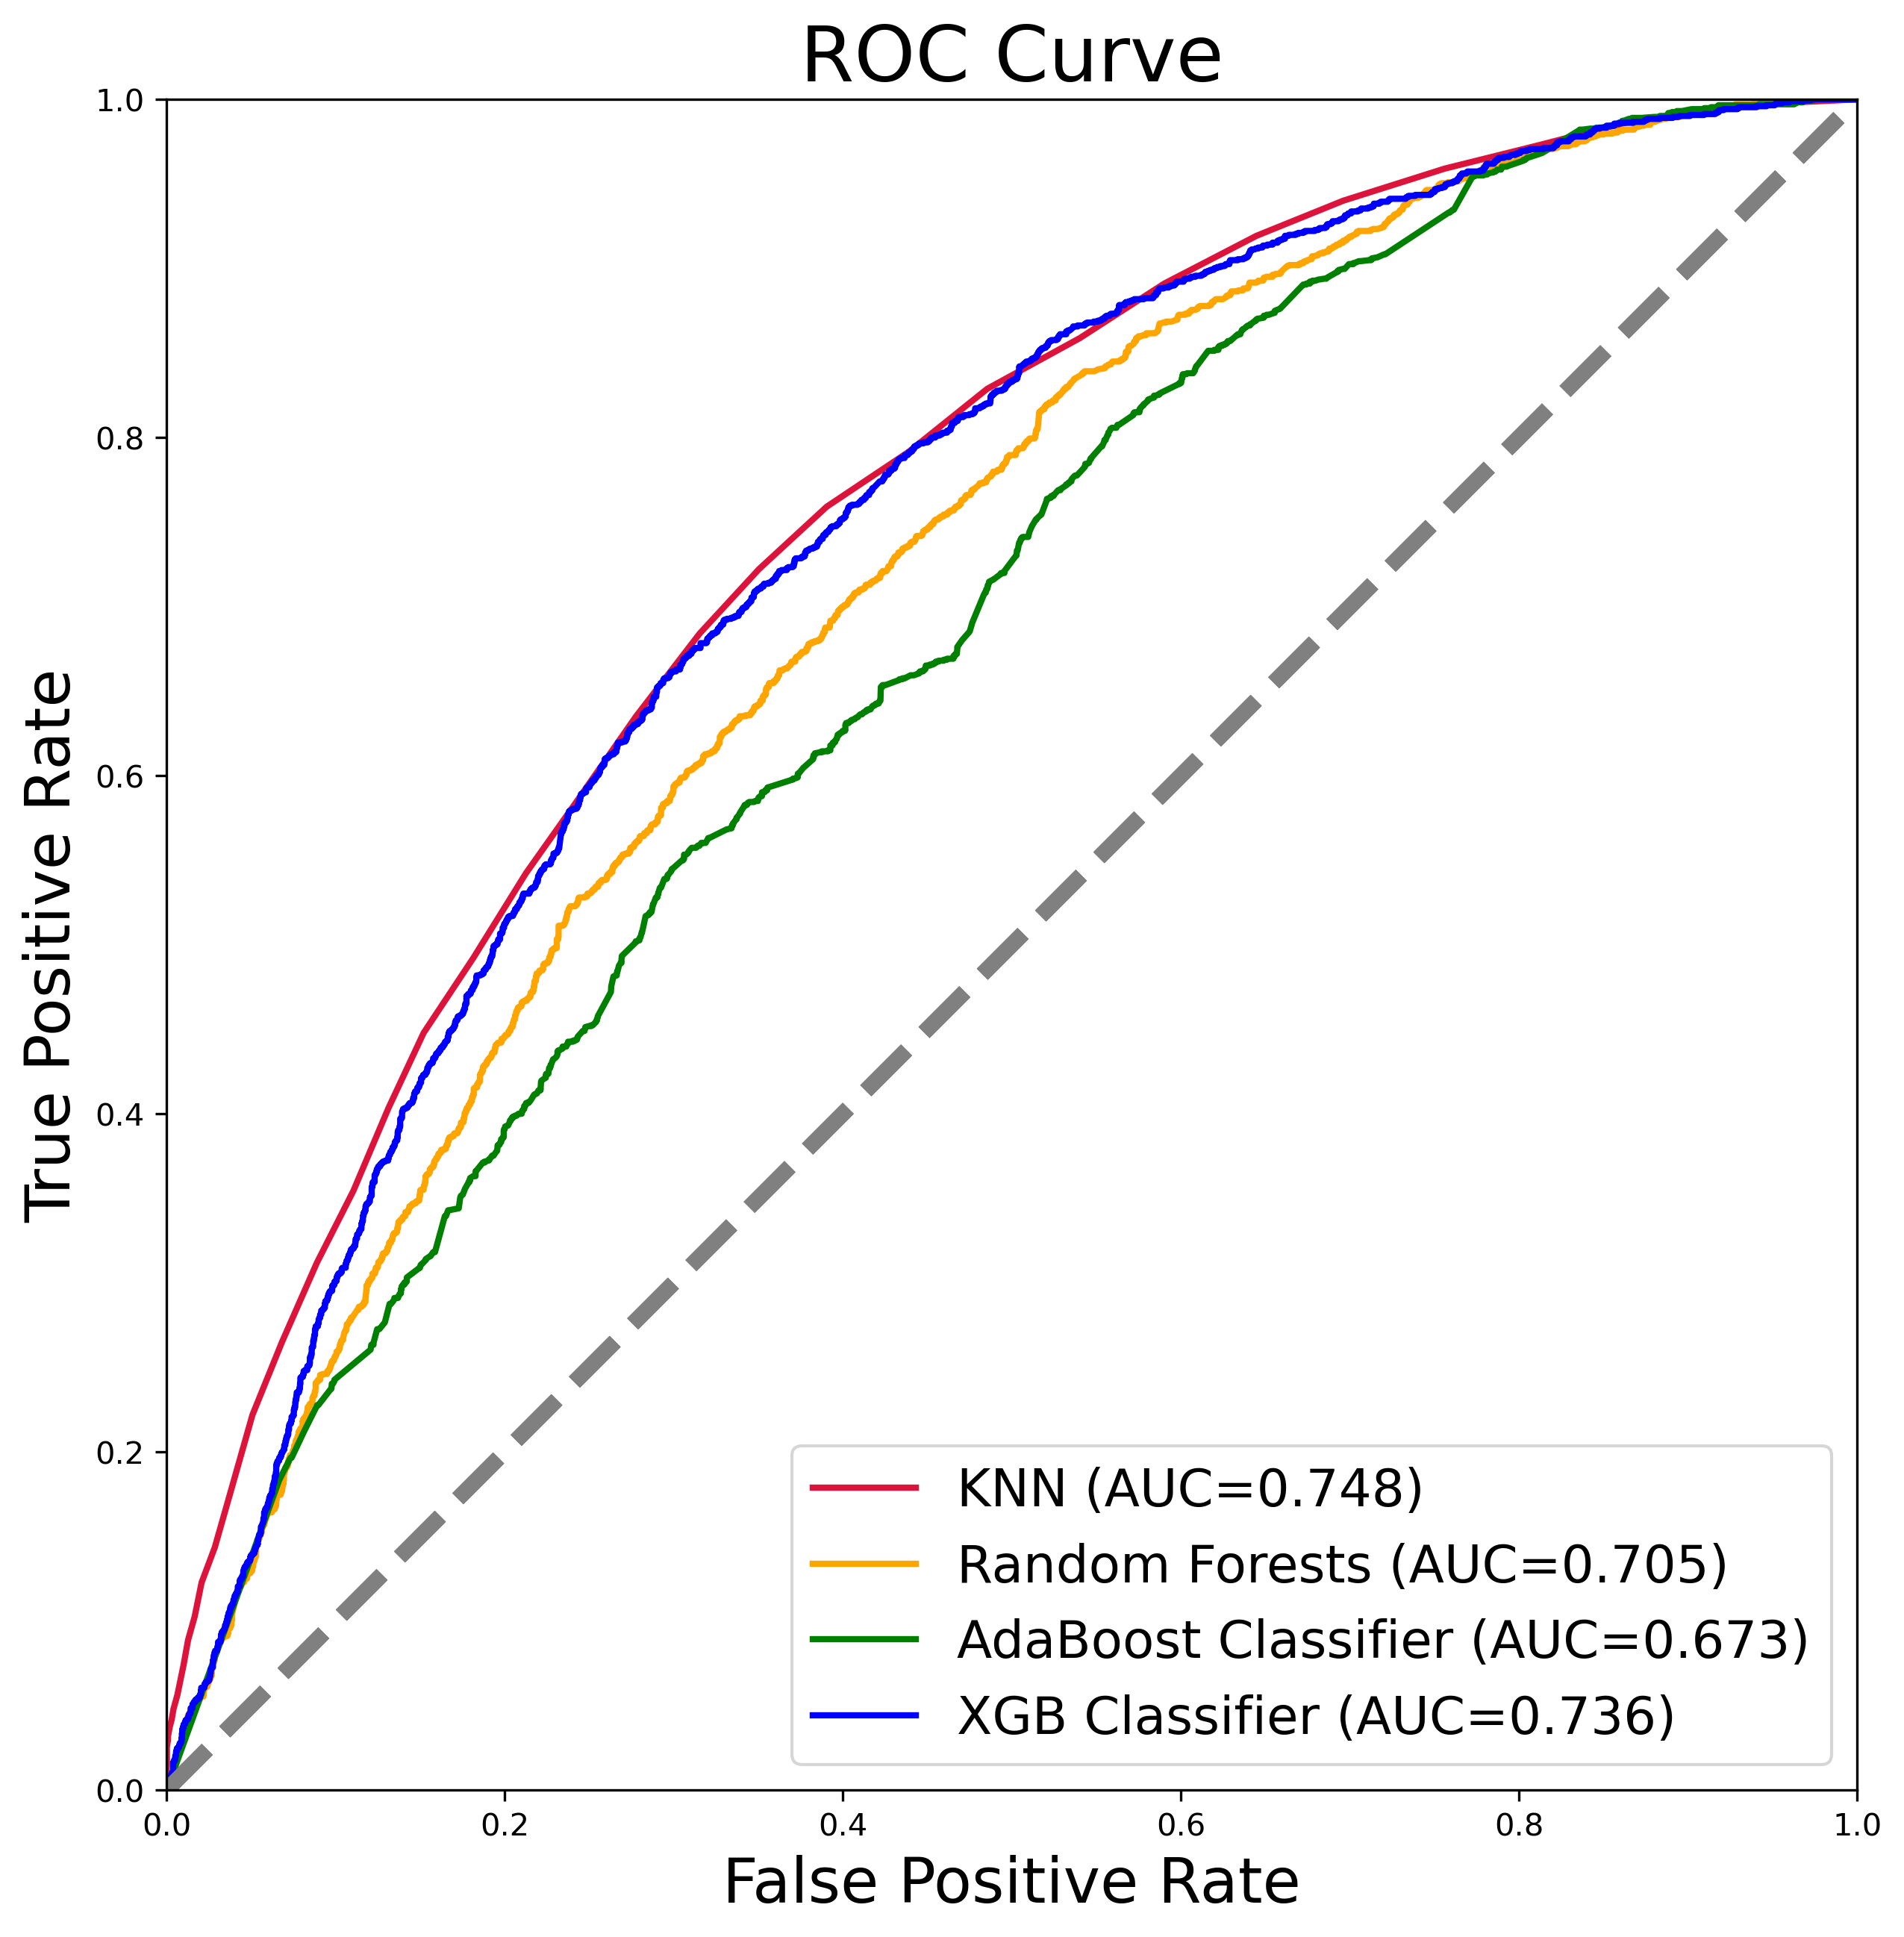

In [23]:
names = ['KNN','Random Forests','AdaBoost Classifier', 'XGB Classifier']

sampling_methods = [model_knn, model_random_forest, model_ada_boost, model_xgb]

colors = ['crimson', 'orange','green','blue', 'plum']

#ROC curves
test_roc_graph = multi_models_roc(names, sampling_methods, colors, x_test, y_test)